In [1]:
%load_ext autoreload
%autoreload 2

# Définition du seuil

source: [Fine tuning the threshold in face recognition](https://sefiks.com/2020/05/22/fine-tuning-the-threshold-in-face-recognition/)

## Génération des identitées

In [36]:
import os
import pandas as pd
import itertools
import cv2
from chefboost import Chefboost as chef
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
current_dir = os.getcwd()
new_dir = current_dir.replace("\\tests", "")
os.chdir(new_dir)
from services.faces.comparators.deepface_comparator import DeepFaceComparator
from services.faces.face_detector import FaceDetector
from services.images.image_editor import ImageEditor
from services.faces.comparators.vgg_face_comparator import VGGFaceComparator

In [3]:
dataset_root = "training\\classifier\\dataset\\val"

def get_person_files(dataset_root) -> dict:
    person_files = {}

    for root, dirs, files in os.walk(dataset_root):
        for dir in dirs:
            person_name = dir
            person_dir = os.path.join(root, dir)
            person_files[person_name] = []

            for file in os.listdir(person_dir):
                if file.endswith(".jpg"):
                    person_files[person_name].append(dir + '\\' + file)

    return person_files

identities = get_person_files(dataset_root)

identities

{'Angelina Jolie': ['Angelina Jolie\\018_fcafe1a8.jpg',
  'Angelina Jolie\\022_b497b92e.jpg',
  'Angelina Jolie\\037_62d00a09.jpg',
  'Angelina Jolie\\045_c560251e.jpg',
  'Angelina Jolie\\050_7c5b026c.jpg',
  'Angelina Jolie\\084_da751ddd.jpg',
  'Angelina Jolie\\087_f325890f.jpg',
  'Angelina Jolie\\090_da55509f.jpg',
  'Angelina Jolie\\092_26130bb1.jpg',
  'Angelina Jolie\\095_0be163a1.jpg'],
 'Brad Pitt': ['Brad Pitt\\012_8de7a736.jpg',
  'Brad Pitt\\014_871b0d80.jpg',
  'Brad Pitt\\017_4748675b.jpg',
  'Brad Pitt\\030_716e4856.jpg',
  'Brad Pitt\\045_6895fe7e.jpg',
  'Brad Pitt\\053_be062c12.jpg',
  'Brad Pitt\\056_8362ff51.jpg',
  'Brad Pitt\\065_34848907.jpg'],
 'Denzel Washington': ['Denzel Washington\\013_5928728c.jpg',
  'Denzel Washington\\014_9742cf0f.jpg',
  'Denzel Washington\\023_75fd6b60.jpg',
  'Denzel Washington\\047_05f6a63f.jpg',
  'Denzel Washington\\051_d27cd673.jpg',
  'Denzel Washington\\057_ce4bc775.jpg',
  'Denzel Washington\\071_30155b02.jpg',
  'Denzel Washi

## Génération de paires positives

In [4]:
positives = []
for key, values in identities.items():
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            positives.append([values[i], values[j]])

positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

positives

,file_x,file_y,decision
0,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\022_b497b92e.jpg,Yes
1,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\037_62d00a09.jpg,Yes
2,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\045_c560251e.jpg,Yes
3,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\050_7c5b026c.jpg,Yes
4,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\084_da751ddd.jpg,Yes
...,...,...,...
731,Will Smith\051_1f3aede9.jpg,Will Smith\072_4a17b7fb.jpg,Yes
732,Will Smith\051_1f3aede9.jpg,Will Smith\087_6eba84a6.jpg,Yes
733,Will Smith\053_8405b30f.jpg,Will Smith\072_4a17b7fb.jpg,Yes
734,Will Smith\053_8405b30f.jpg,Will Smith\087_6eba84a6.jpg,Yes


## Génération de paires négatives

In [5]:
samples_list = list(identities.values())

negatives = []
for i in range(0, len(identities) - 1):
    for j in range(i+1, len(identities)):
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)

    for cross_sample in cross_product:
        negatives.append([cross_sample[0], cross_sample[1]])

negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

negatives

,file_x,file_y,decision
0,Angelina Jolie\018_fcafe1a8.jpg,Will Smith\008_cdaf39e7.jpg,No
1,Angelina Jolie\018_fcafe1a8.jpg,Will Smith\021_3cf2aa92.jpg,No
2,Angelina Jolie\018_fcafe1a8.jpg,Will Smith\030_df8c8fad.jpg,No
3,Angelina Jolie\018_fcafe1a8.jpg,Will Smith\046_6d5b1ed6.jpg,No
4,Angelina Jolie\018_fcafe1a8.jpg,Will Smith\051_1f3aede9.jpg,No
...,...,...,...
1243,Tom Hanks\097_0c9b7ced.jpg,Will Smith\046_6d5b1ed6.jpg,No
1244,Tom Hanks\097_0c9b7ced.jpg,Will Smith\051_1f3aede9.jpg,No
1245,Tom Hanks\097_0c9b7ced.jpg,Will Smith\053_8405b30f.jpg,No
1246,Tom Hanks\097_0c9b7ced.jpg,Will Smith\072_4a17b7fb.jpg,No


## Merge pairs

In [6]:
df: pd.DataFrame = pd.concat([positives, negatives]).reset_index(drop = True)
df.file_x = df.file_x
df.file_y = df.file_y

df

,file_x,file_y,decision
0,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\022_b497b92e.jpg,Yes
1,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\037_62d00a09.jpg,Yes
2,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\045_c560251e.jpg,Yes
3,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\050_7c5b026c.jpg,Yes
4,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\084_da751ddd.jpg,Yes
...,...,...,...
1979,Tom Hanks\097_0c9b7ced.jpg,Will Smith\046_6d5b1ed6.jpg,No
1980,Tom Hanks\097_0c9b7ced.jpg,Will Smith\051_1f3aede9.jpg,No
1981,Tom Hanks\097_0c9b7ced.jpg,Will Smith\053_8405b30f.jpg,No
1982,Tom Hanks\097_0c9b7ced.jpg,Will Smith\072_4a17b7fb.jpg,No


## Distances between pairs

### Comparisons

In [7]:
face_detector = FaceDetector()
face_comparator = DeepFaceComparator()
vgg_face_comparator = VGGFaceComparator()

Yolo FaceDetector model running on: cuda
WARNING ⚠️ NMS time limit 0.550s exceeded
Yolo FaceDetector warmed up.
DeepFace comparator warmed up.
PyTorch VGGFaceComparator model running on: cuda:0
PyTorch VGGFaceComparator warmed up.


#### Comparisons using DeepFace

In [8]:
instances = df[["file_x", "file_y"]].values.tolist()

deepface_distances = []
vgg_face_distances = []

for index, instance in enumerate(instances):
    print(f"[{index+1}/{len(instances)}] - Comparing {instance[0]} and {instance[1]}")
    img1 = cv2.cvtColor(cv2.imread(os.path.join(dataset_root, instance[0])), cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(cv2.imread(os.path.join(dataset_root, instance[1])), cv2.COLOR_BGR2RGB)
    pred1 = face_detector.detect(img1)
    pred2 = face_detector.detect(img2)

    if len(pred1) != 0 and len(pred2) != 0:
        img1 = ImageEditor.crop(img1, pred1[0].bounding_box)
        img2 = ImageEditor.crop(img2, pred2[0].bounding_box)
        deepface_distances.append(face_comparator.compare(img1, img2).distance)
        vgg_face_distances.append(vgg_face_comparator.compare(img1, img2).distance)

df["deepface_distance"] = deepface_distances
df["vgg_face_distance"] = vgg_face_distances

df = df[df["deepface_distance"] >= 0.1]
df = df[df["vgg_face_distance"] >= 0.1]
df

[1/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\022_b497b92e.jpg
[2/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\037_62d00a09.jpg
[3/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\045_c560251e.jpg
[4/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\050_7c5b026c.jpg
[5/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\084_da751ddd.jpg
[6/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\087_f325890f.jpg
[7/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\090_da55509f.jpg
[8/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\092_26130bb1.jpg
[9/1984] - Comparing Angelina Jolie\018_fcafe1a8.jpg and Angelina Jolie\095_0be163a1.jpg
[10/1984] - Comparing Angelina Jolie\022_b497b92e.jpg and Angelina Jolie\037_62d00a09.jpg
[11/1984] - Comparing Angelina Jolie\022_b497b92e.jpg and Angelina Jolie\045_c560251e.jpg
[12/1984] - Compari

,file_x,file_y,decision,deepface_distance,vgg_face_distance
0,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\022_b497b92e.jpg,Yes,0.366601,0.377351
1,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\037_62d00a09.jpg,Yes,0.423913,0.502540
2,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\045_c560251e.jpg,Yes,0.377955,0.389708
3,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\050_7c5b026c.jpg,Yes,0.362633,0.356034
4,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\084_da751ddd.jpg,Yes,0.377908,0.409797
...,...,...,...,...,...
1979,Tom Hanks\097_0c9b7ced.jpg,Will Smith\046_6d5b1ed6.jpg,No,0.629890,0.692644
1980,Tom Hanks\097_0c9b7ced.jpg,Will Smith\051_1f3aede9.jpg,No,0.652923,0.722766
1981,Tom Hanks\097_0c9b7ced.jpg,Will Smith\053_8405b30f.jpg,No,0.673060,0.768213
1982,Tom Hanks\097_0c9b7ced.jpg,Will Smith\072_4a17b7fb.jpg,No,0.565837,0.644251


### Analyze

In [9]:
def analyze(column_name: str) -> (float, float, float, float):
    tp_mean = round(df[df.decision == "Yes"][column_name].mean(), 4)
    tp_std = round(df[df.decision == "Yes"][column_name].std(), 4)
    fp_mean = round(df[df.decision == "No"][column_name].mean(), 4)
    fp_std = round(df[df.decision == "No"][column_name].std(), 4)

    print(f"[{column_name}] True positive mean: {tp_mean} - True positive std: {tp_std}")
    print(f"[{column_name}] False positive mean: {fp_mean} - False positive std: {fp_std}")
    return tp_mean, tp_std, fp_mean, fp_std

In [10]:
df_tp_mean, df_tp_std, df_fp_mean, df_fp_std = analyze("deepface_distance")
vgg_face_tp_mean, vgg_face_tp_std, vgg_face_fp_mean, vgg_face_fp_std = analyze("vgg_face_distance")

[deepface_distance] True positive mean: 0.2916 - True positive std: 0.1069
[deepface_distance] False positive mean: 0.6059 - False positive std: 0.1343
[vgg_face_distance] True positive mean: 0.319 - True positive std: 0.1129
[vgg_face_distance] False positive mean: 0.6756 - False positive std: 0.1411


In [13]:
def plot_distances_distributions(column_name: str, subplot_position: int):
    plt.subplot(1, 2, subplot_position)
    df[df.decision == "Yes"][column_name].plot.kde(label="Yes")
    df[df.decision == "No"][column_name].plot.kde(label="No")
    plt.title(f"Distribution of {column_name} Distances")
    plt.legend()

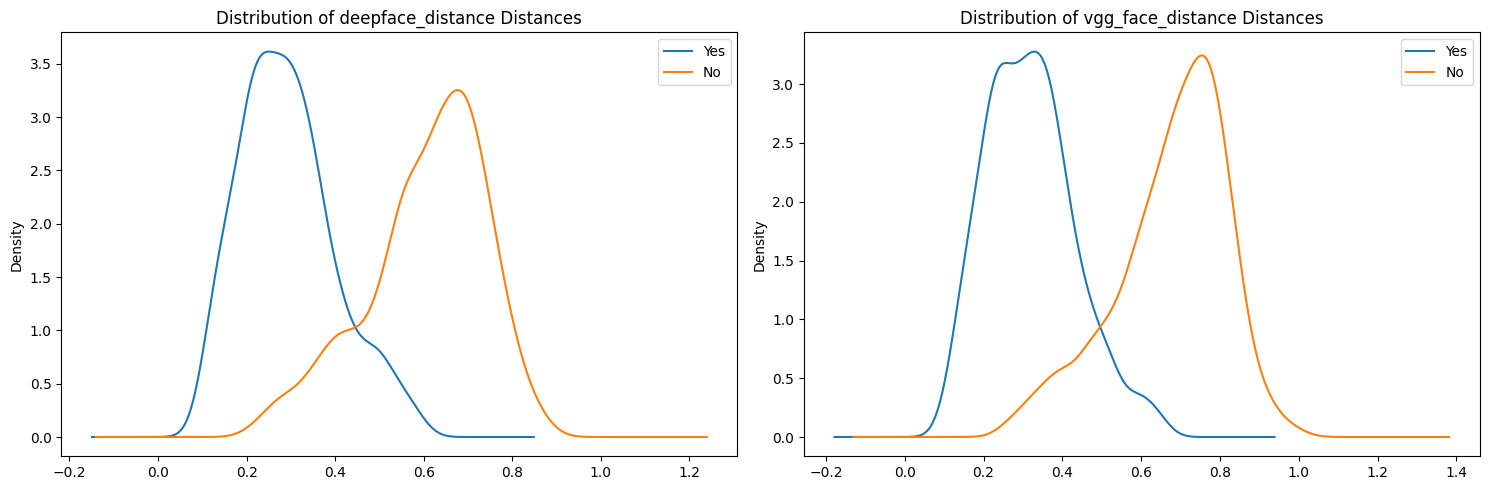

In [16]:
plt.figure(figsize=(15, 5))

plot_distances_distributions("deepface_distance", 1)
plot_distances_distributions("vgg_face_distance", 2)

plt.tight_layout()
plt.show()

### Treshold calculation

In [69]:
def get_1_sigma_threshold(column_name:str) -> float:
    tp_mean, tp_std, fp_mean, fp_std = analyze(column_name)
    return tp_mean + tp_std

def get_2_sigma_threshold(column_name: str) -> float:
    tp_mean, tp_std, fp_mean, fp_std = analyze(column_name)
    return tp_mean + 2 * tp_std

def get_3_sigma_threshold(column_name: str) -> float:
    tp_mean, tp_std, fp_mean, fp_std = analyze(column_name)
    return tp_mean + 3 * tp_std

In [72]:
get_1_sigma_threshold("deepface_distance")
get_1_sigma_threshold("vgg_face_distance")

[deepface_distance] True positive mean: 0.2916 - True positive std: 0.1069
[deepface_distance] False positive mean: 0.6059 - False positive std: 0.1343
[vgg_face_distance] True positive mean: 0.319 - True positive std: 0.1129
[vgg_face_distance] False positive mean: 0.6756 - False positive std: 0.1411


0.4319

In [19]:
deepface_sigma_2_threshold = get_2_sigma_threshold("deepface_distance")
deepface_sigma_3_threshold = get_3_sigma_threshold("deepface_distance")
vgg_face_sigma_2_threshold = get_2_sigma_threshold("vgg_face_distance")
vgg_face_sigma_3_threshold = get_3_sigma_threshold("vgg_face_distance")
print(f"DeepFace 2-Sigma threshold: {deepface_sigma_2_threshold}")
print(f"DeepFace 3-Sigma threshold: {deepface_sigma_3_threshold}")
print(f"VGG-Face 2-Sigma threshold: {vgg_face_sigma_2_threshold}")
print(f"VGG-Face 3-Sigma threshold: {vgg_face_sigma_3_threshold}")

[deepface_distance] True positive mean: 0.2916 - True positive std: 0.1069
[deepface_distance] False positive mean: 0.6059 - False positive std: 0.1343
[deepface_distance] True positive mean: 0.2916 - True positive std: 0.1069
[deepface_distance] False positive mean: 0.6059 - False positive std: 0.1343
[vgg_face_distance] True positive mean: 0.319 - True positive std: 0.1129
[vgg_face_distance] False positive mean: 0.6756 - False positive std: 0.1411
[vgg_face_distance] True positive mean: 0.319 - True positive std: 0.1129
[vgg_face_distance] False positive mean: 0.6756 - False positive std: 0.1411
DeepFace 2-Sigma threshold: 0.5054000000000001
DeepFace 3-Sigma threshold: 0.6123000000000001
VGG-Face 2-Sigma threshold: 0.5448
VGG-Face 3-Sigma threshold: 0.6577


In [20]:
# Generate an output folder and a rules.py file containing the calculated threshold

def get_decision_tree_threshold(column_name: str) -> float:
    config = {'algorithm': 'C4.5'}
    tmp_df = df[[column_name, 'decision']].rename(columns={"decision": "Decision"}).copy()
    print(tmp_df)
    chef.fit(df=tmp_df, config=config, target_label='decision')

In [21]:
get_decision_tree_threshold("deepface_distance")

      deepface_distance Decision
0              0.366601      Yes
1              0.423913      Yes
2              0.377955      Yes
3              0.362633      Yes
4              0.377908      Yes
...                 ...      ...
1979           0.629890       No
1980           0.652923       No
1981           0.673060       No
1982           0.565837       No
1983           0.611475       No

[1956 rows x 2 columns]
[INFO]:  6 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  0.9202876091003418  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  85.68507157464212 % on  1956  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[665, 237], [43, 1011]]
Precision:  73.7251 %, Recall:  93.9266 %, F1:  82.6087 %


In [22]:
get_decision_tree_threshold("vgg_face_distance")

      vgg_face_distance Decision
0              0.377351      Yes
1              0.502540      Yes
2              0.389708      Yes
3              0.356034      Yes
4              0.409797      Yes
...                 ...      ...
1979           0.692644       No
1980           0.722766       No
1981           0.768213       No
1982           0.644251       No
1983           0.663956       No

[1956 rows x 2 columns]
[INFO]:  6 CPU cores will be allocated in parallel running
C4.5  tree is going to be built...
-------------------------
finished in  0.9007818698883057  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  87.52556237218813 % on  1956  instances
Labels:  ['Yes' 'No']
Confusion matrix:  [[682, 218], [26, 1030]]
Precision:  75.7778 %, Recall:  96.3277 %, F1:  84.8259 %


In [27]:
deepface_decision_tree_threshold = 0.49214442708944356
vgg_face_decision_tree_threshold = 0.5465444932203237

### Verification

In [24]:
def replace_last_word(s: str, new_word: str, separator: str = '_') -> str:
    words = s.split(separator)
    words[-1] = new_word
    return separator.join(words)

In [25]:
def set_prediction(column_name: str, sigma_2_threshold: float, sigma_3_threshold: float, decision_tree_threshold: float):
    sigma2_prediction_column_name = replace_last_word(column_name, "prediction") + '_2sigma'
    sigma3_prediction_column_name = replace_last_word(column_name, "prediction") + '_3sigma'
    decision_tree_prediction_column_name = replace_last_word(column_name, "prediction") + '_decision_tree'
    df[sigma2_prediction_column_name] = 'No'
    df[sigma3_prediction_column_name] = 'No'
    df[decision_tree_prediction_column_name] = 'No'

    df.loc[df[column_name] <= sigma_2_threshold, sigma2_prediction_column_name] = 'Yes'
    df.loc[df[column_name] > sigma_2_threshold, sigma2_prediction_column_name] = 'No'
    df.loc[df[column_name] <= sigma_3_threshold, sigma3_prediction_column_name] = 'Yes'
    df.loc[df[column_name] > sigma_3_threshold, sigma3_prediction_column_name] = 'No'
    df.loc[df[column_name] <= decision_tree_threshold, decision_tree_prediction_column_name] = 'Yes'
    df.loc[df[column_name] > decision_tree_threshold, decision_tree_prediction_column_name] = 'No'


In [28]:
set_prediction("deepface_distance", deepface_sigma_2_threshold, deepface_sigma_3_threshold, deepface_decision_tree_threshold)
set_prediction("vgg_face_distance", vgg_face_sigma_2_threshold, vgg_face_sigma_3_threshold, vgg_face_decision_tree_threshold)
df

,file_x,file_y,decision,deepface_distance,vgg_face_distance,deepface_prediction_2sigma,deepface_prediction_3sigma,deepface_prediction_decision_tree,vgg_face_prediction_2sigma,vgg_face_prediction_3sigma,vgg_face_prediction_decision_tree
0,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\022_b497b92e.jpg,Yes,0.366601,0.377351,Yes,Yes,Yes,Yes,Yes,Yes
1,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\037_62d00a09.jpg,Yes,0.423913,0.502540,Yes,Yes,Yes,Yes,Yes,Yes
2,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\045_c560251e.jpg,Yes,0.377955,0.389708,Yes,Yes,Yes,Yes,Yes,Yes
3,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\050_7c5b026c.jpg,Yes,0.362633,0.356034,Yes,Yes,Yes,Yes,Yes,Yes
4,Angelina Jolie\018_fcafe1a8.jpg,Angelina Jolie\084_da751ddd.jpg,Yes,0.377908,0.409797,Yes,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...,...,...,...,...,...
1979,Tom Hanks\097_0c9b7ced.jpg,Will Smith\046_6d5b1ed6.jpg,No,0.629890,0.692644,No,No,No,No,No,No
1980,Tom Hanks\097_0c9b7ced.jpg,Will Smith\051_1f3aede9.jpg,No,0.652923,0.722766,No,No,No,No,No,No
1981,Tom Hanks\097_0c9b7ced.jpg,Will Smith\053_8405b30f.jpg,No,0.673060,0.768213,No,No,No,No,No,No
1982,Tom Hanks\097_0c9b7ced.jpg,Will Smith\072_4a17b7fb.jpg,No,0.565837,0.644251,No,Yes,No,No,Yes,No


### Evaluation

In [67]:
def get_all_confusion_matrices(column_name: str):
    sigma2_prediction_column_name = replace_last_word(column_name, "prediction") + '_2sigma'
    sigma3_prediction_column_name = replace_last_word(column_name, "prediction") + '_3sigma'
    decision_tree_prediction_column_name = replace_last_word(column_name, "prediction") + '_decision_tree'

    sigma2_confusion_matrix = confusion_matrix(df.decision, df[sigma2_prediction_column_name], labels=["Yes", "No"])
    sigma3_confusion_matrix = confusion_matrix(df.decision, df[sigma3_prediction_column_name], labels=["Yes", "No"])
    decision_tree_confusion_matrix = confusion_matrix(df.decision, df[decision_tree_prediction_column_name], labels=["Yes", "No"])

    return sigma2_confusion_matrix, sigma3_confusion_matrix, decision_tree_confusion_matrix

def plot_cm_with_metrics(cm, title, threshold, subplot_position):
    tn, fp, fn, tp = cm.ravel()
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tn + fp + fn + tp)
    f1 = 2 * (precision * recall) / (precision + recall)

    plt.subplot(3, 2, subplot_position)
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdYlBu_r")
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(title)

    # Ajustez ces valeurs pour modifier l'espacement vertical entre les lignes de texte
    text_spacing = 0.06
    start_position = -0.2
    
    plt.text(0.5, start_position, f"Recall: {recall:.3f}", fontsize=10, ha='center', va='top', transform=plt.gca().transAxes)
    plt.text(0.5, start_position - text_spacing, f"Precision: {precision:.3f}", fontsize=10, ha='center', va='top', transform=plt.gca().transAxes)
    plt.text(0.5, start_position - 2 * text_spacing, f"Accuracy: {accuracy:.3f}", fontsize=10, ha='center', va='top', transform=plt.gca().transAxes)
    plt.text(0.5, start_position - 3 * text_spacing, f"F1: {f1:.3f}", fontsize=10, ha='center', va='top', transform=plt.gca().transAxes)
    plt.text(0.5, start_position - 4 * text_spacing, f"Threshold: {threshold:.4f}", fontsize=10, ha='center', va='top', transform=plt.gca().transAxes)



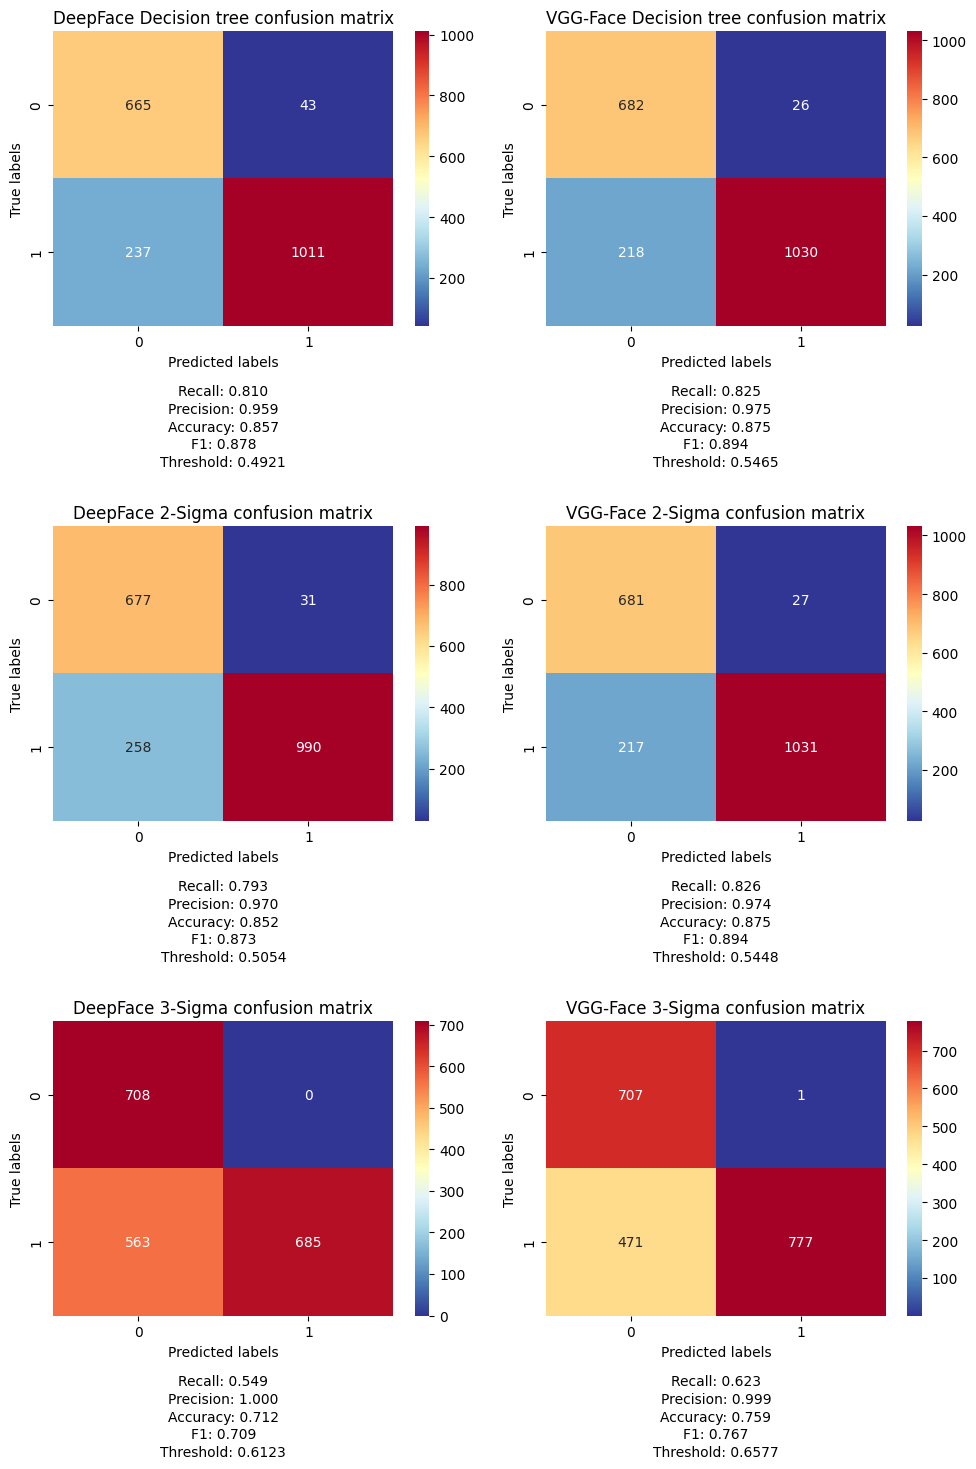

In [68]:
deepface_sigma_2_cm, deepface_sigma_3_cm, decision_tree_cm = get_all_confusion_matrices("deepface_distance")
vgg_face_sigma_2_cm, vgg_face_sigma_3_cm, vgg_face_decision_tree_cm = get_all_confusion_matrices("vgg_face_distance")

plt.figure(figsize=(10, 15))

plot_cm_with_metrics(decision_tree_cm, "DeepFace Decision tree confusion matrix", threshold=deepface_decision_tree_threshold, subplot_position=1)
plot_cm_with_metrics(deepface_sigma_2_cm, "DeepFace 2-Sigma confusion matrix", threshold=deepface_sigma_2_threshold, subplot_position=3)
plot_cm_with_metrics(deepface_sigma_3_cm, "DeepFace 3-Sigma confusion matrix", threshold=deepface_sigma_3_threshold, subplot_position=5)

plot_cm_with_metrics(vgg_face_decision_tree_cm, "VGG-Face Decision tree confusion matrix", threshold=vgg_face_decision_tree_threshold, subplot_position=2)
plot_cm_with_metrics(vgg_face_sigma_2_cm, "VGG-Face 2-Sigma confusion matrix", threshold=vgg_face_sigma_2_threshold, subplot_position=4)
plot_cm_with_metrics(vgg_face_sigma_3_cm, "VGG-Face 3-Sigma confusion matrix", threshold=vgg_face_sigma_3_threshold, subplot_position=6)

plt.tight_layout()
plt.show()